In [23]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

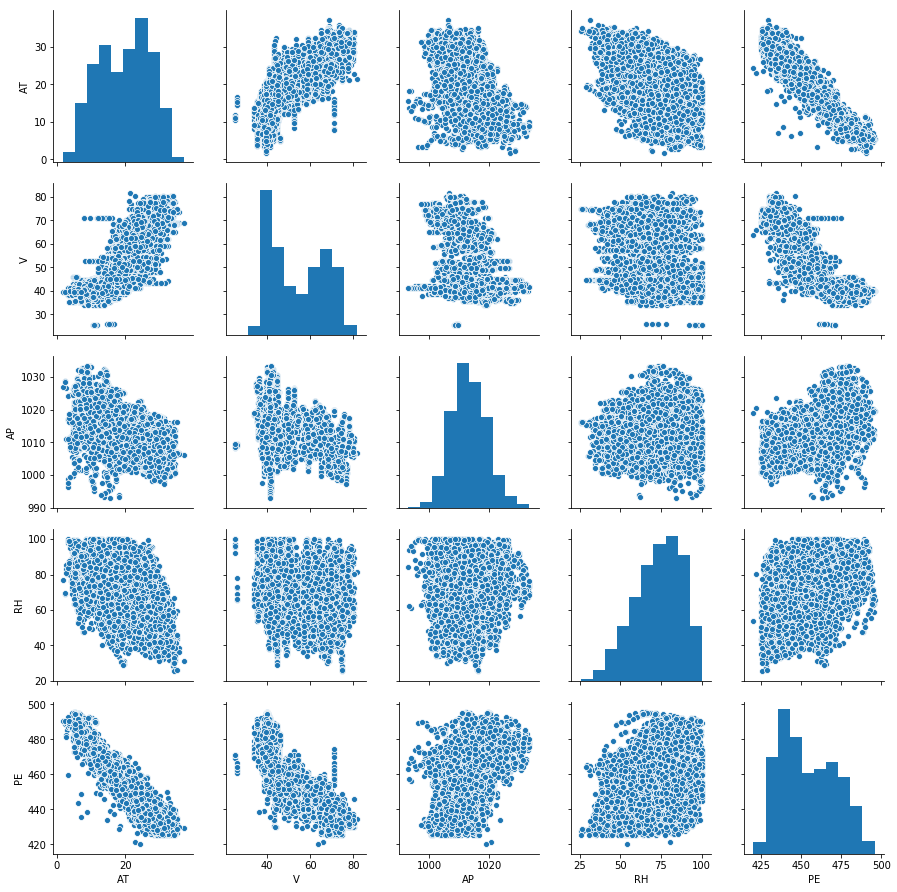

In [24]:
# 数据读取
ccpp = pd.read_csv('用电输出.csv').drop('Unnamed: 0',axis=1)
ccpp.describe()
# AT:温度
# V:压力
# AP:相对湿度
# RH:排气量
# PE:发电量

# 绘制各变量之间的散点图
sns.pairplot(ccpp)
plt.show()

In [25]:
ccpp.corrwith(ccpp.PE)

AT   -0.948128
V    -0.869780
AP    0.518429
RH    0.389794
PE    1.000000
dtype: float64

# 去掉RH指标

In [31]:
ccpp2=ccpp.drop('RH',axis=1)

从返回的结果来看，PE(发电量)与AT(温度)和V(压力)之间的相关系数还是蛮高的，而PE与AP(相对湿度)和RH(排气量)之间的相关系数就明显小很多。<br>
一般情况下，当Pearson相关系数低于0.4，则表明变量之间存在弱相关关系；当Pearson相关系数在0.4~0.6之间，则说明变量之间存在中度相关关系；<br>
当相关系数在0.6以上时，则反映变量之间存在强相关关系。经过对比发现，PE与RH之间的为弱相关关系，故不考虑将该变量纳入模型。<br><br>
当然，变量之间不存在线性关系并不代表不存在任何关系，可能是二次函数关系、对数关系等，所以一般还需要进行检验和变量转换。<br>

# 多重共线性检验

In [29]:
def vif(df, col_i):
    from patsy import dmatrices
    cols = list(df.columns)
    cols.remove(col_i)
    formula = col_i + '~' + '+'.join(cols)
    y, X = dmatrices(formula, data = df, return_type='dataframe')

    # 构造空的数据框
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

In [32]:
vif(ccpp2,'PE')

,VIF Factor,features
0,39847.945838,Intercept
1,3.888380,AT
2,3.482090,V
3,1.348401,AP


先来了解一下，如果模型的自变量之间存在严重的多重共线性的话，会产生什么后果呢?<br>

导致OLS估计量可能无效；<br>

增大OLS估计量的方差；<br>

变量的显著性检验将失去意义；<br>

模型缺乏稳定性；<br>
所以，多重共线性检验就显得非常重要了，关于多重共线性的检验可以使用方差膨胀因子(VIF)来鉴定，如果VIF大于10，则说明变量存在多重共线性。一旦发现变量之间存在多重共线性的话，可以考虑删除变量和重新选择模型（岭回归法）。

# 异常点检测
 在异常点检测之前，我们需要对现有的数据，进行线性回归模型的构造。具体操作如下，与上一期文章中回归模型的建模一致

In [37]:
# 构造PE与AT、V和AP之间的线性模型
fit = sm.formula.ols('PE~AT+V+AP',data = ccpp2).fit()
fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.568e+04
Date:                Fri, 22 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:34:33   Log-Likelihood:                -28758.
No. Observations:                9568   AIC:                         5.752e+04
Df Residuals:                    9564   BIC:                         5.755e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    344.0714      9.977     34.487      0.000     324.515     363.628
AT            -1.6348      0.013   -123.613      0.000      -1.661      -1.609
V             -0.3283      0.007    -44.735      0.000      -0.343      -0.314
AP             0.1582      0.010     16.183      0.000       0.139       0.177
==============================================================================
Omnibus:                      542.551   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1896.378
Skew:                          -0.198   Prob(JB):                         0.00
Kurtosis:                       5.145   Cond. No.                     2.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# 计算模型的RMSE值
pred = fit.predict()
np.sqrt(mean_squared_error(ccpp2.PE, pred))

4.887719834860166

In [39]:
outliers = fit.get_influence()

# 高杠杆值点（帽子矩阵）
leverage = outliers.hat_matrix_diag
# dffits值
dffits = outliers.dffits[0]
# 学生化残差
resid_stu = outliers.resid_studentized_external
# cook距离
cook = outliers.cooks_distance[0]
# covratio值
covratio = outliers.cov_ratio

# 将上面的几种异常值检验统计量与原始数据集合并
contat1 = pd.concat([pd.Series(leverage, name = 'leverage'),pd.Series(dffits, name = 'dffits'),
                     pd.Series(resid_stu,name = 'resid_stu'),pd.Series(cook, name = 'cook'),
                     pd.Series(covratio, name = 'covratio'),],axis = 1)
ccpp_outliers = pd.concat([ccpp,contat1], axis = 1)
ccpp_outliers.head()

,AT,V,AP,RH,PE,leverage,dffits,resid_stu,cook,covratio
0,14.96,41.76,1024.07,73.17,463.26,0.000549,-0.022075,-0.941799,1.218279e-04,1.000597
1,25.18,62.96,1020.04,59.08,444.37,0.000487,0.003668,0.166180,3.363110e-06,1.000894
2,5.11,39.40,1012.16,92.14,488.56,0.000787,0.032756,1.167083,2.682360e-04,1.000636
3,20.86,57.32,1010.24,76.64,446.48,0.000137,-0.010641,-0.908639,2.830953e-05,1.000210
4,10.82,37.50,1009.23,96.62,473.90,0.000514,0.001008,0.044471,2.542535e-07,1.000932


# 通过参考薛毅老师的《统计建模与R软件》书可知，当高杠杆值点（或帽子矩阵）大于2(p+1)/n时，则认为该样本点可能存在异常（其中p为自变量的个数，n为观测的个数）；当DFFITS统计值大于2sqrt((p+1)/n)时 ，则认为该样本点可能存在异常；当学生化残差的绝对值大于2，则认为该样本点可能存在异常；对于cook距离来说，则没有明确的判断标准，一般来说，值越大则为异常点的可能性就越高；对于covratio值来说，如果一个样本的covratio值离数值1越远，则认为该样本越可能是异常值。这里我们就以学生化残差作为评判标准，因为其包含了帽子矩阵和DFFITS的信息。

In [42]:
# 计算异常值数量的比例
outliers_ratio = sum(np.where((np.abs(ccpp_outliers.resid_stu)>2),1,0))/ccpp_outliers.shape[0]
outliers_ratio



0.0

In [41]:
# 删除异常值
ccpp_outliers = ccpp_outliers.loc[np.abs(ccpp_outliers.resid_stu)<=2,]

In [45]:
# 重新建模
fit2 = sm.formula.ols('PE~AT+V+AP',data = ccpp_outliers).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 4.550e+04
Date:                Fri, 22 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:46:43   Log-Likelihood:                -26434.
No. Observations:                9213   AIC:                         5.288e+04
Df Residuals:                    9209   BIC:                         5.291e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    349.8258      8.857     39.498      0.000     332.465     367.187
AT            -1.6719      0.012   -141.063      0.000      -1.695      -1.649
V             -0.3285      0.006    -50.545      0.000      -0.341      -0.316
AP             0.1531      0.009     17.647      0.000       0.136       0.170
==============================================================================
Omnibus:                      455.104   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.929
Skew:                           0.058   Prob(JB):                     6.97e-41
Kurtosis:                       2.316   Cond. No.                     2.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:


# 计算模型的RMSE值
pred2 = fit2.predict()
np.sqrt(mean_squared_error(ccpp_outliers.PE, pred2))

4.264441950064937

# 正态性检验

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib

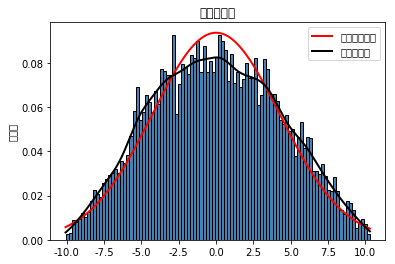

In [48]:
# 残差的正态性检验（直方图法）
resid = fit2.resid

# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

plt.hist(resid, # 绘图数据
        bins = 100, # 指定直方图条的个数
        normed = True, # 设置为频率直方图
        color = 'steelblue', # 指定填充色
        edgecolor = 'k') # 指定直方图的边界色

# 设置坐标轴标签和标题
plt.title('残差直方图')
plt.ylabel('密度值')

# 生成正态曲线的数据
x1 = np.linspace(resid.min(), resid.max(), 1000)
normal = mlab.normpdf(x1, resid.mean(), resid.std())

# 绘制正态分布曲线
plt.plot(x1,normal,'r-', linewidth = 2, label = '正态分布曲线') 

# 生成核密度曲线的数据
kde = mlab.GaussianKDE(resid)
x2 = np.linspace(resid.min(), resid.max(), 1000)

# 绘制核密度曲线
plt.plot(x2,kde(x2),'k-', linewidth = 2, label = '核密度曲线')

# 去除图形顶部边界和右边界的刻度
plt.tick_params(top='off', right='off')

# 显示图例
plt.legend(loc='best')
# 显示图形
plt.show()

# 从残差的直方图来看，核密度曲线与理论的正态分布曲线的趋势还是比较吻合的，即使残差不服从正态分布，也能反映其基本近似于正态分布。

Text(0.5, 1.0, 'Q-Q图')

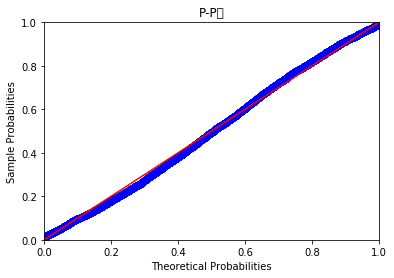

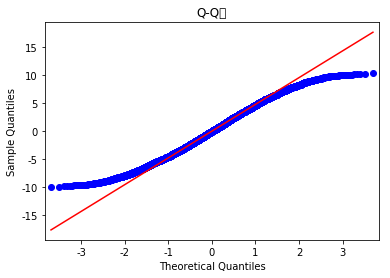

In [49]:
# 残差的正态性检验（PP图和QQ图法）
pp_qq_plot = sm.ProbPlot(resid)

pp_qq_plot.ppplot(line = '45')
plt.title('P-P图')

pp_qq_plot.qqplot(line = 'q')
plt.title('Q-Q图')# 显示图形plt.show()

# 从PP图和QQ图来看，有一部分样本点并没有落在参考线上，但绝大多数样本点还是与参考线保持一致的步调

In [50]:
# 残差的正态性检验（非参数法）
standard_resid = (resid-np.mean(resid))/np.std(resid)
stats.kstest(standard_resid, 'norm')

KstestResult(statistic=0.030784687051174653, pvalue=5.215128860844854e-08)

由于shapiro正态性检验对样本量的要求是5000以内；而本次数据集的样本量由9000多，故选择K-S来完成正态性检验。从K-S检验的P值来看，拒绝了残差服从正态分布的假设，即认为残差并不满足正态性假设这个前提。如果残差不服从正态分布的话，建议对Y变量进行box-cox变换处理。由于fit2模型的残差并没有特别明显的偏态（偏度为0.058，接近于0），故这里就不对Y变量进行box-cox变换了。如果需要变换的话，可以以下面的代码为例：

In [54]:
import scipy.stats as stats
# 找到box-cox变换的lambda系数
lamd = stats.boxcox_normmax(ccpp_outliers.y, method = 'mle')
# 对Y进行变换
your_data_frame['trans_y'] = stats.boxcox(ccpp_outliers.y, lamd)
# 建模
fit = sm.formula.ols('y~x1+x2+...', 
data = your_data_frame).fit()
fit.summary()

AttributeError: 'DataFrame' object has no attribute 'y'